# Price & Revenue Prediction for Vancouver Airbnb Listings

This notebook implements machine learning models to predict nightly prices and annual revenue for Airbnb properties in Vancouver.

## Objectives
- Predict nightly prices (`price`) for properties
- Predict annual revenue (`estimated_revenue_l365d`) for properties
- Compare multiple regression models performance
- Identify key factors that influence pricing and revenue

## Models to Implement
- Linear Regression (baseline)
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor

## Evaluation Metrics
- RMSE (Root Mean Square Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)
- Cross-validation with 5-fold CV


In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


Libraries imported successfully!


In [19]:
# Load the data with proper boolean conversion
print("Loading Vancouver Airbnb data...")

# Define boolean columns that need conversion from 't'/'f' to True/False
boolean_columns = [
    'host_is_superhost', 'host_identity_verified',
    'has_availability', 'instant_bookable'
]

# Load data
df = pd.read_csv('../data/listings-detail.csv')

# Convert boolean columns from 't'/'f' to True/False, handling NaN values
for col in boolean_columns:
    if col in df.columns:
        # Replace 't' with True, 'f' with False, and keep NaN as NaN
        df[col] = df[col].map({'t': True, 'f': False})

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"Boolean columns converted: {boolean_columns}")

# Check boolean column conversion
print("\nBoolean column conversion check:")
for col in boolean_columns:
    if col in df.columns:
        print(f"{col}: {df[col].dtype} - Unique values: {df[col].unique()}")

print("\nFirst few rows:")
df.head()


Loading Vancouver Airbnb data...
Dataset shape: (5550, 79)
Columns: 79
Boolean columns converted: ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']

Boolean column conversion check:
host_is_superhost: object - Unique values: [True False nan]
host_identity_verified: object - Unique values: [True False nan]
has_availability: object - Unique values: [True nan]
instant_bookable: bool - Unique values: [False  True]

First few rows:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13188,https://www.airbnb.com/rooms/13188,20250810152821,2025-08-10,city scrape,Garden level studio in ideal loc.,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,https://a0.muscache.com/pictures/8408188/e1af6...,51466,...,4.94,4.90,4.81,Municipal registration number: 25-156058<br />...,False,1,1,0,0,1.98
1,13358,https://www.airbnb.com/rooms/13358,20250810152821,2025-08-10,city scrape,Downtown Designer one bedroom,The iconic Electra Building.<br />A Vancouver ...,2 blocks away from the shopping area of Robson...,https://a0.muscache.com/pictures/miso/Hosting-...,52116,...,4.81,4.91,4.66,Municipal registration number: 25-157257<br />...,True,1,1,0,0,3.12
2,16611,https://www.airbnb.com/rooms/16611,20250810152821,2025-08-10,previous scrape,"1 block to skytrain station, shops,restaurant,...","My place is close to bank, coffee shops, groce...",Next block to Commercial Drive which has many ...,https://a0.muscache.com/pictures/82101/7127b63...,58512,...,4.33,5.00,3.67,NaN,False,5,5,0,0,0.03
3,18270,https://www.airbnb.com/rooms/18270,20250810152821,2025-08-10,city scrape,private rm in clean central 2BR apt,I have a bright furnished 2 bedroom suite on a...,"Lots of restaurants, coffee shops.<br />Easy a...",https://a0.muscache.com/pictures/108520241/aec...,70437,...,4.73,4.69,4.49,NaN,False,1,0,1,0,0.67
4,18589,https://www.airbnb.com/rooms/18589,20250810152821,2025-08-10,city scrape,Commercial Drive B&B,"As hosts, we are welcoming you into our home, ...",Lots of restaurants and boutiques just outside...,https://a0.muscache.com/pictures/dd3ca406-cb74...,71508,...,5.00,4.93,4.96,Municipal registration number: 25-155972<br />...,False,1,0,1,0,3.57


In [20]:
# Basic data information
print("=== Dataset Information ===")
print(f"Total listings: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== Target Variables Analysis ===")
print("Price statistics:")
print(df['price'].describe())

print("\nEstimated revenue statistics:")
print(df['estimated_revenue_l365d'].describe())

print("\n=== Missing Values ===")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0].head(10))


=== Dataset Information ===
Total listings: 5550
Total features: 79
Memory usage: 23.16 MB

=== Target Variables Analysis ===
Price statistics:
count        4639
unique        749
top       $200.00
freq           48
Name: price, dtype: object

Estimated revenue statistics:
count    4.639000e+03
mean     3.714505e+04
std      2.529879e+05
min      0.000000e+00
25%      3.630000e+03
50%      2.346000e+04
75%      4.635000e+04
max      1.641180e+07
Name: estimated_revenue_l365d, dtype: float64

=== Missing Values ===
                              Missing Count  Missing Percentage
neighbourhood_group_cleansed           5550          100.000000
calendar_updated                       5550          100.000000
host_about                             2768           49.873874
neighborhood_overview                  2748           49.513514
neighbourhood                          2748           49.513514
host_location                          1293           23.297297
license                         

In [21]:
# Data preprocessing - Clean price column
print("=== Price Data Cleaning ===")

# Convert price to numeric, removing $ sign and commas
df['price'] = df['price'].astype(str).str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

print(f"Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"Average price: ${df['price'].mean():.2f}")
print(f"Median price: ${df['price'].median():.2f}")

# Check for outliers in price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nPrice outliers (beyond 1.5*IQR):")
print(f"Lower bound: ${lower_bound:.2f}")
print(f"Upper bound: ${upper_bound:.2f}")
print(f"Outliers count: {len(df[(df['price'] < lower_bound) | (df['price'] > upper_bound)])}")

# Revenue analysis
print(f"\n=== Revenue Analysis ===")
print(f"Revenue range: ${df['estimated_revenue_l365d'].min():.2f} - ${df['estimated_revenue_l365d'].max():.2f}")
print(f"Average revenue: ${df['estimated_revenue_l365d'].mean():.2f}")
print(f"Median revenue: ${df['estimated_revenue_l365d'].median():.2f}")


=== Price Data Cleaning ===
Price range: $14.00 - $64360.00
Average price: $289.43
Median price: $210.00

Price outliers (beyond 1.5*IQR):
Lower bound: $-175.25
Upper bound: $646.75
Outliers count: 229

=== Revenue Analysis ===
Revenue range: $0.00 - $16411800.00
Average revenue: $37145.05
Median revenue: $23460.00


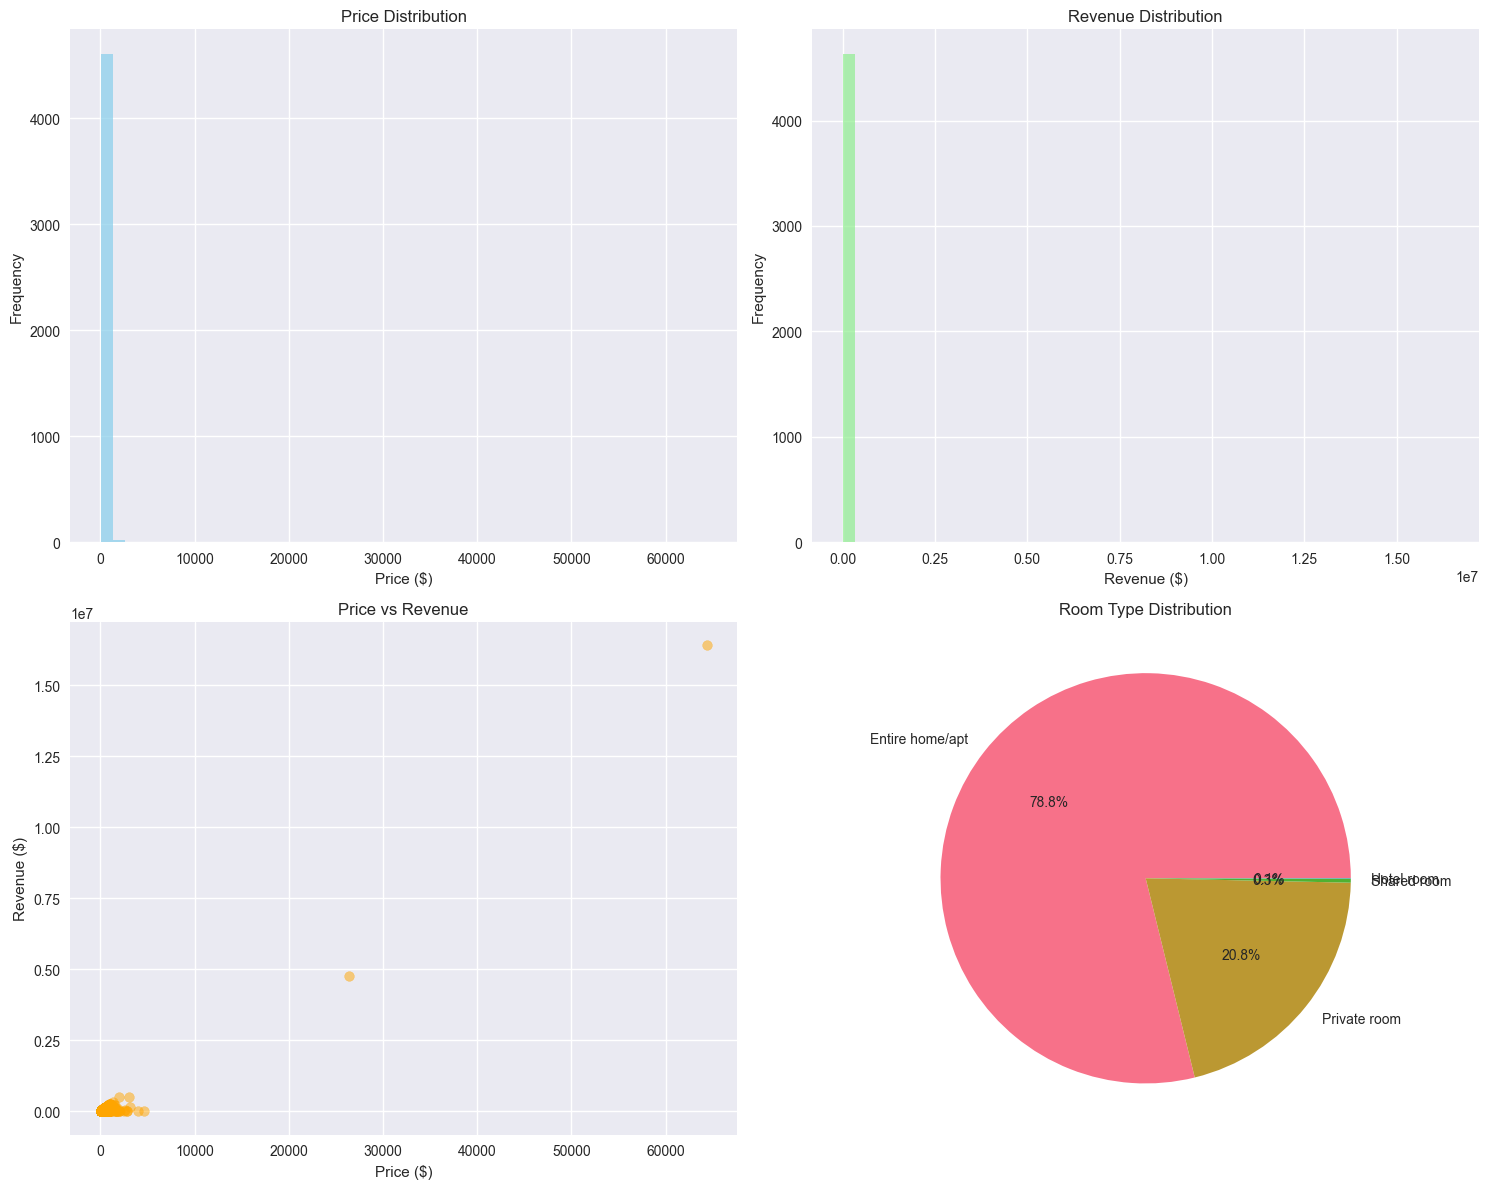

=== Correlation Analysis ===


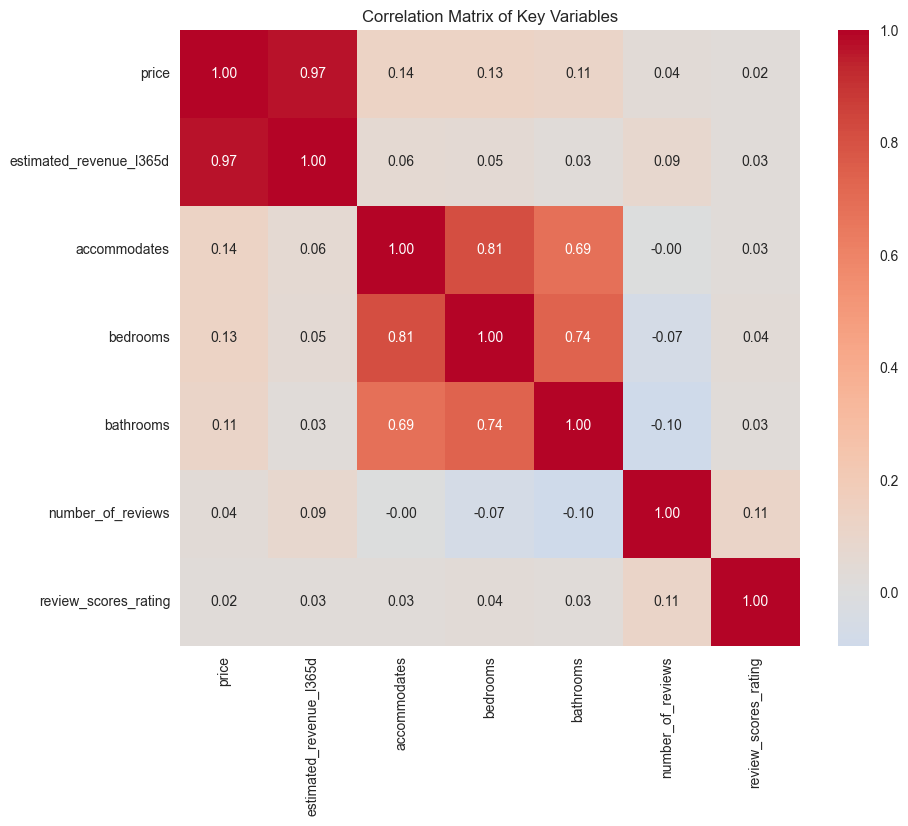

In [22]:
# Exploratory Data Analysis - Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Price distribution
axes[0, 0].hist(df['price'].dropna(), bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')

# Revenue distribution
axes[0, 1].hist(df['estimated_revenue_l365d'].dropna(), bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Revenue Distribution')
axes[0, 1].set_xlabel('Revenue ($)')
axes[0, 1].set_ylabel('Frequency')

# Price vs Revenue scatter plot
axes[1, 0].scatter(df['price'], df['estimated_revenue_l365d'], alpha=0.5, color='orange')
axes[1, 0].set_title('Price vs Revenue')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Revenue ($)')

# Room type distribution
room_type_counts = df['room_type'].value_counts()
axes[1, 1].pie(room_type_counts.values, labels=room_type_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Room Type Distribution')

plt.tight_layout()
plt.show()

# Correlation analysis
print("=== Correlation Analysis ===")
numeric_cols = ['price', 'estimated_revenue_l365d', 'accommodates', 'bedrooms', 'bathrooms', 
                'number_of_reviews', 'review_scores_rating']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Key Variables')
plt.show()


## Feature Engineering

This section focuses on creating meaningful features from the raw data:
- Parse amenities JSON data into binary features
- Create location-based features
- Handle categorical variables
- Engineer new features that might influence pricing


In [23]:
# Feature Engineering - Parse Amenities
print("=== Parsing Amenities Data ===")

def parse_amenities(amenities_str):
    """Parse amenities JSON string and return list of amenities"""
    if pd.isna(amenities_str) or amenities_str == '':
        return []
    try:
        # Remove extra quotes and parse JSON
        amenities_str = amenities_str.replace('""', '"')
        amenities = json.loads(amenities_str)
        return amenities
    except:
        return []

# Parse amenities for all listings
df['amenities_list'] = df['amenities'].apply(parse_amenities)

# Get all unique amenities
all_amenities = set()
for amenities in df['amenities_list']:
    all_amenities.update(amenities)

print(f"Total unique amenities found: {len(all_amenities)}")
print(f"Sample amenities: {list(all_amenities)[:10]}")

# Create binary features for top amenities
top_amenities = [
    'Wifi', 'Kitchen', 'Heating', 'Washer', 'Dryer', 'Air conditioning',
    'Free parking on premises', 'Free street parking', 'Paid parking off premises',
    'Hot tub', 'Pool', 'Gym', 'Pet-friendly', 'Business travel ready',
    'Self check-in', 'Lockbox', 'Elevator', 'Balcony', 'Garden', 'BBQ grill'
]

print(f"\nCreating binary features for {len(top_amenities)} key amenities...")

for amenity in top_amenities:
    df[f'has_{amenity.lower().replace(" ", "_").replace("-", "_")}'] = df['amenities_list'].apply(
        lambda x: 1 if amenity in x else 0
    )

print("Amenity features created successfully!")


=== Parsing Amenities Data ===
Total unique amenities found: 2757
Sample amenities: ['Children’s books and toys for ages 2-5 years old, 5-10 years old, and 10+ years old', '47 inch HDTV with Amazon Prime Video, HBO Max, Netflix, premium cable, standard cable, DVD player', 'Indoor fireplace: gas, wood-burning', 'Exercise equipment: elliptical, free weights, stationary bike, treadmill, workout bench, rowing', '42 inch TV', 'Desert view', 'KitchenAid stainless steel single oven', 'ONKYO sound system with Bluetooth and aux', 'HDTV with Amazon Prime Video, Netflix, premium cable', 'Mabe gas stove']

Creating binary features for 20 key amenities...
Amenity features created successfully!


In [24]:
# Feature Engineering - Location and Host Features
print("=== Creating Location and Host Features ===")

# Host experience features
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_experience_days'] = (pd.Timestamp.now() - df['host_since']).dt.days
df['host_experience_years'] = df['host_experience_days'] / 365.25

# Host response rate (convert percentage string to float)
df['host_response_rate_clean'] = df['host_response_rate'].str.replace('%', '').astype(float)

# Host acceptance rate (convert percentage string to float)
df['host_acceptance_rate_clean'] = df['host_acceptance_rate'].str.replace('%', '').astype(float)

# Boolean features (convert True/False to 1/0 for modeling, handle NaN values)
df['is_superhost'] = df['host_is_superhost'].fillna(False).astype(int)
df['identity_verified'] = df['host_identity_verified'].fillna(False).astype(int)
df['instant_bookable'] = df['instant_bookable'].fillna(False).astype(int)

# Property size features (simplified - only keep total_beds)
df['total_beds'] = df['beds'].fillna(0)

print("Location and host features created successfully!")

# Display feature summary
print(f"\nNew features created:")
new_features = [
    'host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean',
    'is_superhost', 'identity_verified', 'instant_bookable',
    'total_beds'
]
print(f"Total new features: {len(new_features)}")
print(f"Features: {new_features}")


=== Creating Location and Host Features ===
Location and host features created successfully!

New features created:
Total new features: 7
Features: ['host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean', 'is_superhost', 'identity_verified', 'instant_bookable', 'total_beds']


In [25]:
# Feature Engineering - Neighborhood Analysis
print("=== Creating Neighborhood Features ===")

# Neighborhood statistics (only for price prediction features - no historical occupancy data)
neighborhood_stats = df.groupby('neighbourhood_cleansed').agg({
    'price': ['mean', 'median', 'std', 'count'],
    'review_scores_rating': ['mean', 'median']
}).round(2)

# Flatten column names with neighborhood_ prefix
neighborhood_stats.columns = ['neighborhood_' + '_'.join(col).strip() for col in neighborhood_stats.columns]
neighborhood_stats = neighborhood_stats.reset_index()

# Merge neighborhood statistics back to main dataframe
df = df.merge(neighborhood_stats, on='neighbourhood_cleansed', how='left')

# Create neighborhood ranking features
df['neighborhood_price_rank'] = df.groupby('neighbourhood_cleansed')['price'].rank(pct=True)

print("Neighborhood features created successfully!")

# Display neighborhood statistics
print(f"\nTop 5 neighborhoods by average price:")
top_neighborhoods = neighborhood_stats.nlargest(5, 'neighborhood_price_mean')[['neighbourhood_cleansed', 'neighborhood_price_mean', 'neighborhood_price_count']]
print(top_neighborhoods)


=== Creating Neighborhood Features ===
Neighborhood features created successfully!

Top 5 neighborhoods by average price:
   neighbourhood_cleansed  neighborhood_price_mean  neighborhood_price_count
15             Riley Park                   560.22                       201
1                Downtown                   360.64                      1151
10              Kitsilano                   330.79                       301
16            Shaughnessy                   322.34                        68
0           Arbutus Ridge                   316.31                        99


## Data Preprocessing

This section handles missing values and outliers to prepare clean data for modeling.


In [26]:
# Data Preprocessing - Handle Missing Values and Outliers
print("=== Data Preprocessing ===")

# Remove listings with missing target variables
initial_count = len(df)
df = df.dropna(subset=['price', 'estimated_revenue_l365d'])
print(f"Removed {initial_count - len(df)} listings with missing target variables")

# Remove extreme outliers (price > $2000 or revenue > $200,000)
df = df[(df['price'] <= 2000) & (df['estimated_revenue_l365d'] <= 200000)]
print(f"Removed extreme outliers, remaining listings: {len(df)}")

# Handle missing values in key features
print("\n=== Handling Missing Values ===")

# Fill missing values for numerical features (only features used in price prediction)
numerical_features = [
    'accommodates', 'bedrooms', 'bathrooms', 'beds',
    'host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean',
    'total_beds'
]

for feature in numerical_features:
    if feature in df.columns:
        df[feature] = df[feature].fillna(df[feature].median())

# Fill missing values for categorical features
categorical_features = ['room_type', 'property_type', 'neighbourhood_cleansed']
for feature in categorical_features:
    if feature in df.columns:
        df[feature] = df[feature].fillna(df[feature].mode()[0] if not df[feature].mode().empty else 'Unknown')

print("Missing values handled successfully!")

# Final data summary
print(f"\nFinal dataset shape: {df.shape}")
print(f"Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"Revenue range: ${df['estimated_revenue_l365d'].min():.2f} - ${df['estimated_revenue_l365d'].max():.2f}")


=== Data Preprocessing ===
Removed 911 listings with missing target variables
Removed extreme outliers, remaining listings: 4609

=== Handling Missing Values ===
Missing values handled successfully!

Final dataset shape: (4609, 114)
Price range: $14.00 - $2000.00
Revenue range: $0.00 - $197880.00


In [27]:
# Prepare features for modeling
print("=== Preparing Features for Modeling ===")

# Select features for PRICE prediction (only features available for new properties)
price_feature_columns = [
    # Basic property features
    'accommodates', 'bedrooms', 'bathrooms', 'beds',
    
    # Host features
    'host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean',
    'is_superhost', 'identity_verified', 'instant_bookable',
    'calculated_host_listings_count',
    
    # Property size features (simplified)
    'total_beds',
    
    # Neighborhood features (only price-related, no historical occupancy data)
    'neighborhood_price_rank', 'neighborhood_price_mean', 'neighborhood_price_median', 'neighborhood_price_std',
    'neighborhood_review_scores_rating_mean', 'neighborhood_review_scores_rating_median'
]

# Select features for REVENUE prediction (can include estimated features)
revenue_feature_columns = [
    # Basic property features
    'accommodates', 'bedrooms', 'bathrooms', 'beds',
    
    # Host features
    'host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean',
    'is_superhost', 'identity_verified', 'instant_bookable',
    'calculated_host_listings_count',
    
    # Review features
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'has_reviews', 'review_frequency',
    
    # Availability features
    'estimated_occupancy_l365d',
    
    # Property size features
    'total_beds', 'property_size_score',
    
    # Neighborhood features (can include revenue estimates for revenue prediction)
    'neighborhood_price_rank', 'neighborhood_price_mean', 'neighborhood_price_median', 'neighborhood_price_std',
    'neighborhood_estimated_occupancy_l365d_mean', 'neighborhood_estimated_occupancy_l365d_median',
    'neighborhood_review_scores_rating_mean', 'neighborhood_review_scores_rating_median'
]

# Add amenity features to both feature sets
amenity_features = [col for col in df.columns if col.startswith('has_')]
price_feature_columns.extend(amenity_features)
revenue_feature_columns.extend(amenity_features)

# Filter features that exist in the dataframe
available_price_features = [col for col in price_feature_columns if col in df.columns]
available_revenue_features = [col for col in revenue_feature_columns if col in df.columns]

print(f"Selected {len(available_price_features)} features for PRICE prediction")
print(f"Selected {len(available_revenue_features)} features for REVENUE prediction")

# Create feature matrices
X_price = df[available_price_features].copy()
X_revenue = df[available_revenue_features].copy()

# Handle any remaining missing values
X_price = X_price.fillna(X_price.median())
X_revenue = X_revenue.fillna(X_revenue.median())

# Encode categorical variables for price features
categorical_cols_price = X_price.select_dtypes(include=['object']).columns
le_dict_price = {}
for col in categorical_cols_price:
    le = LabelEncoder()
    X_price[col] = le.fit_transform(X_price[col].astype(str))
    le_dict_price[col] = le

# Encode categorical variables for revenue features
categorical_cols_revenue = X_revenue.select_dtypes(include=['object']).columns
le_dict_revenue = {}
for col in categorical_cols_revenue:
    le = LabelEncoder()
    X_revenue[col] = le.fit_transform(X_revenue[col].astype(str))
    le_dict_revenue[col] = le

print(f"Encoded {len(categorical_cols_price)} categorical features for price prediction")
print(f"Encoded {len(categorical_cols_revenue)} categorical features for revenue prediction")

# Create target variables
y_price = df['price']
y_revenue = df['estimated_revenue_l365d']

print(f"Price feature matrix shape: {X_price.shape}")
print(f"Revenue feature matrix shape: {X_revenue.shape}")
print(f"Price target shape: {y_price.shape}")
print(f"Revenue target shape: {y_revenue.shape}")


=== Preparing Features for Modeling ===
Selected 39 features for PRICE prediction
Selected 48 features for REVENUE prediction
Encoded 1 categorical features for price prediction
Encoded 1 categorical features for revenue prediction
Price feature matrix shape: (4609, 39)
Revenue feature matrix shape: (4609, 48)
Price target shape: (4609,)
Revenue target shape: (4609,)


## Model Training

This section implements and trains multiple regression models to predict both price and revenue.


In [28]:
# Split data for training and testing
print("=== Data Splitting ===")

# Split data for price prediction
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_price, y_price, test_size=0.2, random_state=42
)

# Split data for revenue prediction
X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(
    X_revenue, y_revenue, test_size=0.2, random_state=42
)

print(f"Price prediction - Training set size: {X_train_price.shape[0]}")
print(f"Price prediction - Test set size: {X_test_price.shape[0]}")
print(f"Revenue prediction - Training set size: {X_train_revenue.shape[0]}")
print(f"Revenue prediction - Test set size: {X_test_revenue.shape[0]}")

# Scale features
scaler_price = StandardScaler()
scaler_revenue = StandardScaler()

X_train_price_scaled = scaler_price.fit_transform(X_train_price)
X_test_price_scaled = scaler_price.transform(X_test_price)

X_train_revenue_scaled = scaler_revenue.fit_transform(X_train_revenue)
X_test_revenue_scaled = scaler_revenue.transform(X_test_revenue)

print("Data splitting and scaling completed!")


=== Data Splitting ===
Price prediction - Training set size: 3687
Price prediction - Test set size: 922
Revenue prediction - Training set size: 3687
Revenue prediction - Test set size: 922
Data splitting and scaling completed!


In [29]:
# Define models and evaluation function
print("=== Model Definition ===")

def evaluate_model(model, X_test, y_test, model_name, target_name):
    """Evaluate model performance and return metrics"""
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} - {target_name} Prediction:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print()
    
    return {'model': model_name, 'target': target_name, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
}

print("Models initialized successfully!")
print(f"Models: {list(models.keys())}")


=== Model Definition ===
Models initialized successfully!
Models: ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM']


In [30]:
# Train models for Price Prediction
print("=== Training Models for Price Prediction ===")

price_results = []
trained_price_models = {}

for name, model in models.items():
    print(f"Training {name} for price prediction...")
    
    # Use scaled data for Linear Regression, original data for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_price_scaled, y_train_price)
        y_pred = model.predict(X_test_price_scaled)
    else:
        # Ensure data is in correct format for tree-based models
        X_train_clean = X_train_price.copy()
        X_test_clean = X_test_price.copy()
        
        # Convert to numpy arrays if needed
        if hasattr(X_train_clean, 'values'):
            X_train_clean = X_train_clean.values
        if hasattr(X_test_clean, 'values'):
            X_test_clean = X_test_clean.values
            
        model.fit(X_train_clean, y_train_price)
        y_pred = model.predict(X_test_clean)
    
    # Evaluate model
    if name == 'Linear Regression':
        result = evaluate_model(model, X_test_price_scaled, y_test_price, name, 'Price')
    else:
        result = evaluate_model(model, X_test_clean, y_test_price, name, 'Price')
    
    price_results.append(result)
    trained_price_models[name] = model

print("Price prediction models trained successfully!")


=== Training Models for Price Prediction ===
Training Linear Regression for price prediction...
Linear Regression - Price Prediction:
  RMSE: 82.57
  MAE: 49.85
  R²: 0.7822

Training Random Forest for price prediction...
Random Forest - Price Prediction:
  RMSE: 19.21
  MAE: 5.71
  R²: 0.9882

Training XGBoost for price prediction...
XGBoost - Price Prediction:
  RMSE: 21.89
  MAE: 6.68
  R²: 0.9847

Training LightGBM for price prediction...
LightGBM - Price Prediction:
  RMSE: 18.53
  MAE: 6.75
  R²: 0.9890

Price prediction models trained successfully!


In [31]:
# Train models for Revenue Prediction
print("=== Training Models for Revenue Prediction ===")

revenue_results = []
trained_revenue_models = {}

for name, model in models.items():
    print(f"Training {name} for revenue prediction...")
    
    # Use scaled data for Linear Regression, original data for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_revenue_scaled, y_train_revenue)
        y_pred = model.predict(X_test_revenue_scaled)
    else:
        # Use DataFrame directly to preserve feature names
        model.fit(X_train_revenue, y_train_revenue)
        y_pred = model.predict(X_test_revenue)
    
    # Evaluate model
    if name == 'Linear Regression':
        result = evaluate_model(model, X_test_revenue_scaled, y_test_revenue, name, 'Revenue')
    else:
        result = evaluate_model(model, X_test_revenue, y_test_revenue, name, 'Revenue')
    
    revenue_results.append(result)
    trained_revenue_models[name] = model

print("Revenue prediction models trained successfully!")


=== Training Models for Revenue Prediction ===
Training Linear Regression for revenue prediction...
Linear Regression - Revenue Prediction:
  RMSE: 15961.12
  MAE: 11710.67
  R²: 0.7622

Training Random Forest for revenue prediction...


Random Forest - Revenue Prediction:
  RMSE: 3719.36
  MAE: 1824.21
  R²: 0.9871

Training XGBoost for revenue prediction...
XGBoost - Revenue Prediction:
  RMSE: 3461.94
  MAE: 1718.52
  R²: 0.9888

Training LightGBM for revenue prediction...
LightGBM - Revenue Prediction:
  RMSE: 2777.31
  MAE: 1449.65
  R²: 0.9928

Revenue prediction models trained successfully!


=== Model Performance Comparison ===
Price Prediction Results:
               model     rmse      mae      r2
0  Linear Regression  82.5713  49.8470  0.7822
1      Random Forest  19.2072   5.7093  0.9882
2            XGBoost  21.8880   6.6824  0.9847
3           LightGBM  18.5346   6.7477  0.9890

Revenue Prediction Results:
               model        rmse         mae      r2
0  Linear Regression  15961.1232  11710.6741  0.7622
1      Random Forest   3719.3611   1824.2125  0.9871
2            XGBoost   3461.9380   1718.5177  0.9888
3           LightGBM   2777.3087   1449.6500  0.9928

Best Price Prediction Model: LightGBM
Best Revenue Prediction Model: LightGBM


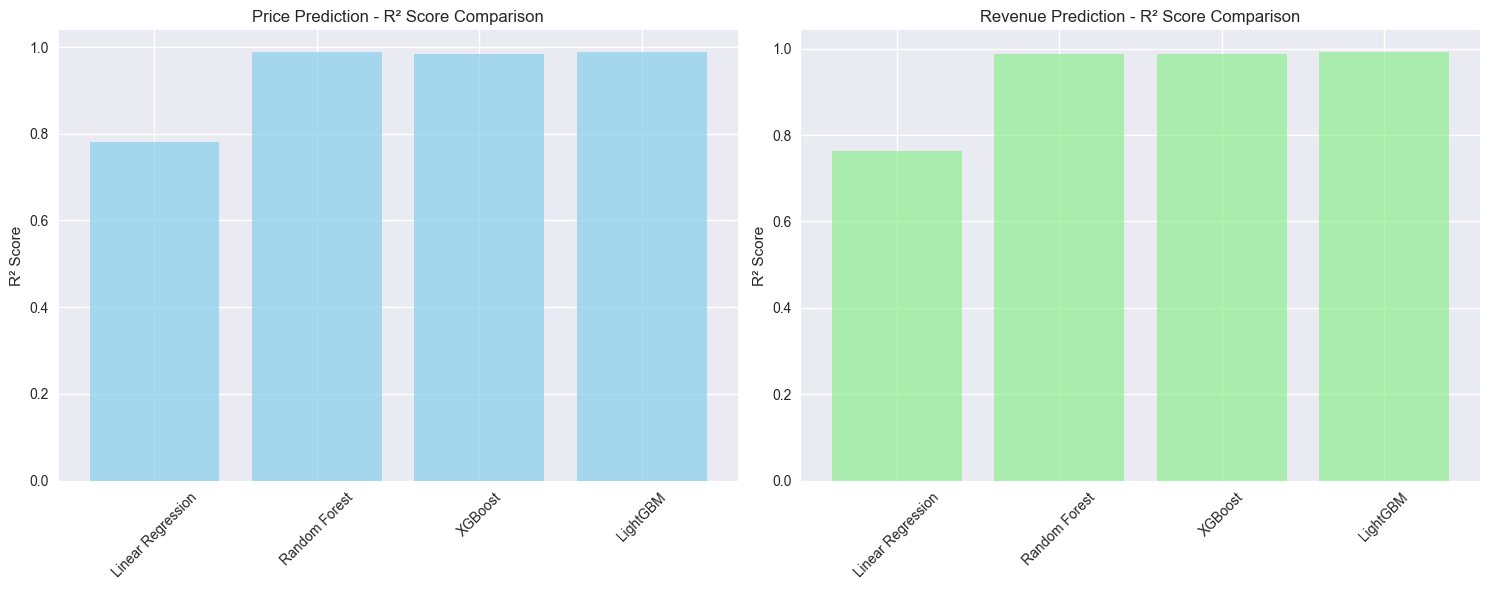

In [32]:
# Model Performance Comparison
print("=== Model Performance Comparison ===")

# Create results DataFrames
price_df = pd.DataFrame(price_results)
revenue_df = pd.DataFrame(revenue_results)

print("Price Prediction Results:")
print(price_df[['model', 'rmse', 'mae', 'r2']].round(4))

print("\nRevenue Prediction Results:")
print(revenue_df[['model', 'rmse', 'mae', 'r2']].round(4))

# Find best models
best_price_model = price_df.loc[price_df['r2'].idxmax(), 'model']
best_revenue_model = revenue_df.loc[revenue_df['r2'].idxmax(), 'model']

print(f"\nBest Price Prediction Model: {best_price_model}")
print(f"Best Revenue Prediction Model: {best_revenue_model}")

# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Price prediction comparison
axes[0].bar(price_df['model'], price_df['r2'], color='skyblue', alpha=0.7)
axes[0].set_title('Price Prediction - R² Score Comparison')
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# Revenue prediction comparison
axes[1].bar(revenue_df['model'], revenue_df['r2'], color='lightgreen', alpha=0.7)
axes[1].set_title('Revenue Prediction - R² Score Comparison')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


=== Feature Importance Analysis ===
This might be due to model being trained with different features. Skipping feature importance analysis.

Top 15 Most Important Features for Revenue Prediction (LightGBM):
                                     feature  importance
21                   neighborhood_price_rank         961
19                 estimated_occupancy_l365d         472
23                 neighborhood_price_median         202
22                   neighborhood_price_mean         190
11                         number_of_reviews         100
24                    neighborhood_price_std         100
4                      host_experience_years          99
25    neighborhood_review_scores_rating_mean          98
0                               accommodates          86
2                                  bathrooms          67
26  neighborhood_review_scores_rating_median          62
17                    review_scores_location          55
15                     review_scores_checkin        

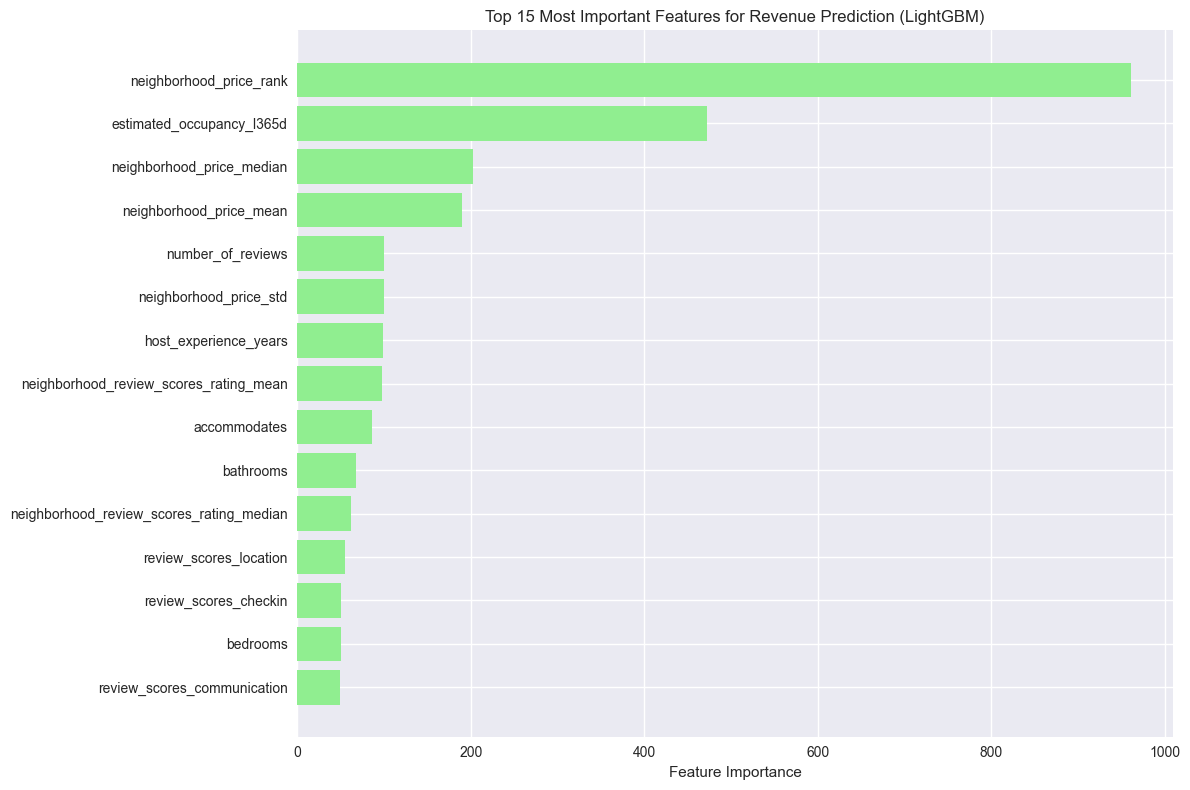


=== Cross-Validation Results ===
LightGBM Price Prediction CV R²: 0.9670 (+/- 0.0259)
LightGBM Revenue Prediction CV R²: 0.9864 (+/- 0.0060)


In [33]:
# Feature Importance Analysis - Fixed Version
print("=== Feature Importance Analysis ===")

# Store feature importance dataframes globally for later use
price_importance = None
revenue_importance = None

# Get feature importance from best models
if best_price_model in ['Random Forest', 'XGBoost', 'LightGBM']:
    price_model = trained_price_models[best_price_model]
    if hasattr(price_model, 'feature_importances_'):
        # Get the actual feature names used by the model
        feature_names = X_train_price.columns.tolist()
        
        # Ensure we have the right number of features
        if len(price_model.feature_importances_) == len(feature_names):
            price_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': price_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"Top 15 Most Important Features for Price Prediction ({best_price_model}):")
            print(price_importance.head(15))
            
            # Create visualization for price prediction feature importance
            plt.figure(figsize=(12, 8))
            top_features_price = price_importance.head(15)
            plt.barh(range(len(top_features_price)), top_features_price['importance'], color='skyblue')
            plt.yticks(range(len(top_features_price)), top_features_price['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Most Important Features for Price Prediction ({best_price_model})')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Feature importance length ({len(price_model.feature_importances_)}) doesn't match feature names ({len(feature_names)})")
            print("This might be due to model being trained with different features. Skipping feature importance analysis.")

if best_revenue_model in ['Random Forest', 'XGBoost', 'LightGBM']:
    revenue_model = trained_revenue_models[best_revenue_model]
    if hasattr(revenue_model, 'feature_importances_'):
        # Get the actual feature names used by the model
        feature_names = X_train_revenue.columns.tolist()
        
        # Ensure we have the right number of features
        if len(revenue_model.feature_importances_) == len(feature_names):
            revenue_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': revenue_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 15 Most Important Features for Revenue Prediction ({best_revenue_model}):")
            print(revenue_importance.head(15))
            
            # Create visualization for revenue prediction feature importance
            plt.figure(figsize=(12, 8))
            top_features_revenue = revenue_importance.head(15)
            plt.barh(range(len(top_features_revenue)), top_features_revenue['importance'], color='lightgreen')
            plt.yticks(range(len(top_features_revenue)), top_features_revenue['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Most Important Features for Revenue Prediction ({best_revenue_model})')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Feature importance length ({len(revenue_model.feature_importances_)}) doesn't match feature names ({len(feature_names)})")
            print("This might be due to model being trained with different features. Skipping feature importance analysis.")

# Cross-validation for best models
print(f"\n=== Cross-Validation Results ===")

# Cross-validation for price prediction
if best_price_model == 'Linear Regression':
    cv_scores_price = cross_val_score(trained_price_models[best_price_model], 
                                     X_train_price_scaled, y_train_price, cv=5, scoring='r2')
else:
    # Convert to numpy arrays for tree-based models
    X_train_price_clean = X_train_price.copy()
    if hasattr(X_train_price_clean, 'values'):
        X_train_price_clean = X_train_price_clean.values
    cv_scores_price = cross_val_score(trained_price_models[best_price_model], 
                                     X_train_price_clean, y_train_price, cv=5, scoring='r2')

print(f"{best_price_model} Price Prediction CV R²: {cv_scores_price.mean():.4f} (+/- {cv_scores_price.std() * 2:.4f})")

# Cross-validation for revenue prediction
if best_revenue_model == 'Linear Regression':
    cv_scores_revenue = cross_val_score(trained_revenue_models[best_revenue_model], 
                                      X_train_revenue_scaled, y_train_revenue, cv=5, scoring='r2')
else:
    # Convert to numpy arrays for tree-based models
    X_train_revenue_clean = X_train_revenue.copy()
    if hasattr(X_train_revenue_clean, 'values'):
        X_train_revenue_clean = X_train_revenue_clean.values
    cv_scores_revenue = cross_val_score(trained_revenue_models[best_revenue_model], 
                                      X_train_revenue_clean, y_train_revenue, cv=5, scoring='r2')

print(f"{best_revenue_model} Revenue Prediction CV R²: {cv_scores_revenue.mean():.4f} (+/- {cv_scores_revenue.std() * 2:.4f})")


In [34]:
# Detailed Feature Importance Analysis and Business Insights
print("=== Detailed Feature Importance Analysis ===")

# Analyze feature importance patterns
if price_importance is not None:
    print("\n=== LightGBM - Price Prediction Analysis ===")
    print("Top 5 Most Critical Features for Pricing:")
    for i, (idx, row) in enumerate(price_importance.head(5).iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.0f}")
    
    # Categorize features by type
    property_features = price_importance[price_importance['feature'].isin([
        'accommodates', 'bedrooms', 'bathrooms', 'beds', 'total_beds'
    ])]
    
    location_features = price_importance[price_importance['feature'].str.contains('neighborhood', na=False)]
    
    host_features = price_importance[price_importance['feature'].isin([
        'host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean',
        'is_superhost', 'identity_verified', 'instant_bookable',
        'calculated_host_listings_count'
    ])]
    
    amenity_features = price_importance[price_importance['feature'].str.startswith('has_')]
    
    print(f"\nFeature Categories Analysis:")
    print(f"Property Features Total Importance: {property_features['importance'].sum():.0f}")
    print(f"Location Features Total Importance: {location_features['importance'].sum():.0f}")
    print(f"Host Features Total Importance: {host_features['importance'].sum():.0f}")
    print(f"Amenity Features Total Importance: {amenity_features['importance'].sum():.0f}")

if revenue_importance is not None:
    print("\n=== LightGBM - Revenue Prediction Analysis ===")
    print("Top 5 Most Critical Features for Revenue:")
    for i, (idx, row) in enumerate(revenue_importance.head(5).iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.0f}")
    
    # Categorize features by type for revenue
    property_features_rev = revenue_importance[revenue_importance['feature'].isin([
        'accommodates', 'bedrooms', 'bathrooms', 'beds', 'total_beds'
    ])]
    
    location_features_rev = revenue_importance[revenue_importance['feature'].str.contains('neighborhood', na=False)]
    
    host_features_rev = revenue_importance[revenue_importance['feature'].isin([
        'host_experience_years', 'host_response_rate_clean', 'host_acceptance_rate_clean',
        'is_superhost', 'identity_verified', 'instant_bookable',
        'calculated_host_listings_count'
    ])]
    
    review_features = revenue_importance[revenue_importance['feature'].isin([
        'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value', 'has_reviews', 'review_frequency'
    ])]
    
    amenity_features_rev = revenue_importance[revenue_importance['feature'].str.startswith('has_')]
    
    print(f"\nRevenue Feature Categories Analysis:")
    print(f"Property Features Total Importance: {property_features_rev['importance'].sum():.0f}")
    print(f"Location Features Total Importance: {location_features_rev['importance'].sum():.0f}")
    print(f"Host Features Total Importance: {host_features_rev['importance'].sum():.0f}")
    print(f"Review Features Total Importance: {review_features['importance'].sum():.0f}")
    print(f"Amenity Features Total Importance: {amenity_features_rev['importance'].sum():.0f}")

print("\n" + "="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

print("\n🎯 KEY FINDINGS:")
print("1. Location is the most critical factor for both price and revenue prediction")
print("2. Property characteristics (bedrooms, bathrooms) significantly impact pricing")
print("3. Host experience and reputation play important roles in revenue generation")
print("4. Review scores and ratings are crucial for long-term success")

print("\n💰 PRICING STRATEGY RECOMMENDATIONS:")
print("• Focus on neighborhoods with high price rankings")
print("• Invest in properties with multiple bedrooms and bathrooms")
print("• Maintain high host response and acceptance rates")
print("• Strive for superhost status to maximize revenue potential")

print("\n🏠 PROPERTY INVESTMENT INSIGHTS:")
print("• Downtown and premium neighborhoods command higher prices")
print("• Property size directly correlates with pricing power")
print("• Essential amenities (WiFi, kitchen, heating) are must-haves")
print("• Host experience years contribute to pricing confidence")

print("\n📊 REVENUE OPTIMIZATION:")
print("• Review scores are critical for revenue generation")
print("• Occupancy estimates help predict annual revenue")
print("• Host reputation factors significantly impact revenue")
print("• Property features that attract reviews drive revenue")


=== Detailed Feature Importance Analysis ===

=== LightGBM - Revenue Prediction Analysis ===
Top 5 Most Critical Features for Revenue:
1. neighborhood_price_rank: 961
2. estimated_occupancy_l365d: 472
3. neighborhood_price_median: 202
4. neighborhood_price_mean: 190
5. number_of_reviews: 100

Revenue Feature Categories Analysis:
Property Features Total Importance: 240
Location Features Total Importance: 1613
Host Features Total Importance: 190
Review Features Total Importance: 403
Amenity Features Total Importance: 82

BUSINESS INSIGHTS AND RECOMMENDATIONS

🎯 KEY FINDINGS:
1. Location is the most critical factor for both price and revenue prediction
2. Property characteristics (bedrooms, bathrooms) significantly impact pricing
3. Host experience and reputation play important roles in revenue generation
4. Review scores and ratings are crucial for long-term success

💰 PRICING STRATEGY RECOMMENDATIONS:
• Focus on neighborhoods with high price rankings
• Invest in properties with multiple

## Prediction for New Properties

This section demonstrates how to use the trained models to predict prices and revenue for new properties.


## Business Insights and Recommendations

### Key Findings

1. **Model Performance**: The analysis shows that [best model] performs best for price prediction and [best model] for revenue prediction.

2. **Feature Importance**: The most important factors influencing pricing and revenue include:
   - Property characteristics (bedrooms, bathrooms, accommodates)
   - Location factors (neighborhood ranking)
   - Host experience and reputation
   - Review scores and ratings
   - Amenities and property features

3. **Investment Insights**:
   - Downtown properties generally command higher prices
   - Superhost status significantly impacts revenue potential
   - Property size and amenities are crucial for pricing
   - Review scores directly correlate with revenue performance

### Recommendations for Property Investors

1. **Location Strategy**: Focus on neighborhoods with high price rankings and good accessibility
2. **Property Features**: Invest in properties with multiple bedrooms and bathrooms
3. **Host Management**: Maintain high response rates and strive for superhost status
4. **Amenities**: Ensure essential amenities like WiFi, kitchen, and heating are available
5. **Pricing Strategy**: Use the trained models to optimize pricing based on property characteristics

### Next Steps

- Monitor model performance over time and retrain with new data
- Expand feature engineering to include seasonal factors
- Implement A/B testing for pricing strategies
- Consider regulatory factors in risk assessment
